### Connect to Drive

In [65]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [66]:
%cd /gdrive/MyDrive/Salvatore_Homework2

/gdrive/MyDrive/Salvatore_Homework2


In [67]:
!pip install tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries

In [68]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
import logging
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from random import shuffle
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [69]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)
#### Human Activity Recognition

##Load Dataset

In [70]:
x_dataset = np.load("x_train.npy")
y_dataset = np.load("y_train.npy")
print("X_train shape : ",x_dataset.shape)
print("y_train shape : ",y_dataset.shape)

X_train shape :  (2429, 36, 6)
y_train shape :  (2429,)


##Plot data for each feature

0


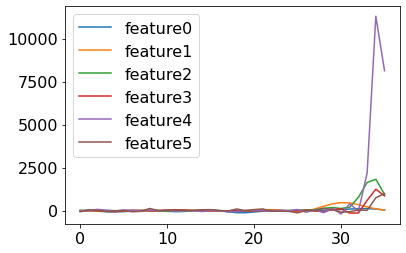

1


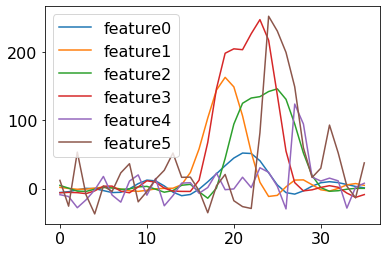

In [71]:
# for i in range(x_dataset.shape[0]):
#     plt.figure(figsize=(20,3))
#     plt.plot(x_dataset[:,:,i])    
#     #plt.axhline(y=X_mean[i],color='darkorange',linestyle='-',label='mean')
#     #plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',linestyle='--',alpha=.5,label='2 std')
#     #plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',linestyle='--',alpha=.5)
#     plt.legend()
#     plt.title('Feature '+str(i))
print(y_dataset[0])
plt.plot(x_dataset[0,:,0],label="feature0")
plt.plot(x_dataset[0,:,1],label="feature1")
plt.plot(x_dataset[0,:,2],label="feature2")
plt.plot(x_dataset[0,:,3],label="feature3")
plt.plot(x_dataset[0,:,4],label="feature4")
plt.plot(x_dataset[0,:,5],label="feature5")

plt.legend()
plt.show()

print(y_dataset[100])
plt.plot(x_dataset[100,:,0],label="feature0")
plt.plot(x_dataset[100,:,1],label="feature1")
plt.plot(x_dataset[100,:,2],label="feature2")
plt.plot(x_dataset[100,:,3],label="feature3")
plt.plot(x_dataset[100,:,4],label="feature4")
plt.plot(x_dataset[100,:,5],label="feature5")

plt.legend()
plt.show()

##Scaler

In [72]:
import pickle
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_dataset = scaler.fit_transform(x_dataset.reshape(-1, x_dataset.shape[-1])).reshape(x_dataset.shape)

file = open('scaler', 'wb')
pickle.dump(scaler, file)
file.close()

##Feature Reduction

In [ ]:
##Concatenate y to x
# data has shape (2429, 36, 6)
# target has shape (2429,)

# add two new axes to target
y_dataset = np.expand_dims(y_dataset, axis=-1)
y_dataset = np.expand_dims(y_dataset, axis=-1)
# repeat elements of target along the second axis
y_dataset = np.repeat(y_dataset, 36, axis=1)
# concatenate data and target along the last axis
result = np.concatenate((x_dataset, y_dataset), axis=-1)
print(result.shape)
# result will have shape (2429, 36, 7)##Feature reduction
X = result[:, :, :-1]
y = result[:, :, -1]
# Define a function to compute the correlation coefficient between each feature and the target variable
def compute_corr(X_i, y_i):
    return np.corrcoef(X_i, y_i)[:-1, -1]
# Compute the correlation coefficients along the second axis (timestamps)
corr = np.apply_along_axis(compute_corr, 1, X, y)

# Extract the correlation coefficients for each feature at each timestamp
feature_corrs = corr[:, :, :-1]

# Select the indices of the features with the highest absolute correlations at each timestamp
indices = np.abs(feature_corrs).argsort(axis=2)[:, :, ::-1]
# Select the top N features at each timestamp
N = 5
top_features = indices[:, :, :N]
top_features

In [19]:
indices = [0,1,2,3]

# Select the subset of features using the indices
subset = np.take(x_dataset, indices, axis=2)
subset.shape

(2429, 36, 4)

##Window slicing

In [12]:
## Change window size
# Set the window size and stride
window_size = 20
stride = 10
# Get the shape of the input array
num_samples, num_timestamps, num_features = x_dataset.shape

In [13]:
# Initialize an empty list to store the windows
windows = []
labels = []
# Loop over the samples
for n in range(num_samples):
  # Loop over the timestamps with the desired stride
  for t in range(0, num_timestamps - window_size + 1, stride):
    # Get the current window
    window = x_dataset[n,t:t+window_size, :]
    label = y_dataset[n]
    # Append the window to the list
    windows.append(window)
    labels.append(label)
# Get the shape of the input array
num_samples, num_timestamps, num_features = x_dataset.shape

In [14]:
# Initialize an empty list to store the windows
windows = []
labels = []
# Loop over the samples
for n in range(num_samples):
  # Loop over the timestamps with the desired stride
  for t in range(0, num_timestamps - window_size + 1, stride):
    # Get the current window
    window = x_dataset[n,t:t+window_size, :]
    label = y_dataset[n]
    # Append the window to the list
    windows.append(window)
    labels.append(label)

In [15]:
# Convert the list of windows to a numpy array
windows = np.array(windows)
labels = np.array(labels)

In [16]:
windows.shape, labels.shape
input_shape = windows.shape[1:]
windows.shape,labels.shape

((4858, 20, 6), (4858,))

##Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, stratify=y_dataset)
print(x_train.shape)
print(y_train.shape)

print('y_dataset:', Counter(y_dataset))
print('y_train_da:', Counter(y_train))
x_val=x_test
y_val=y_test
'''
#test size is the percentage of validation
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.6, stratify=y_test)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

print('y_test_da:', Counter(y_test))
print('y_val_da:', Counter(y_val))
'''

(1943, 36, 6)
(1943,)
y_dataset: Counter({9: 777, 3: 381, 6: 313, 2: 270, 5: 153, 1: 123, 8: 120, 10: 77, 7: 68, 4: 62, 11: 51, 0: 34})
y_train_da: Counter({9: 622, 3: 305, 6: 250, 2: 216, 5: 122, 1: 98, 8: 96, 10: 62, 7: 54, 4: 50, 11: 41, 0: 27})


"\n#test size is the percentage of validation\nfrom sklearn.model_selection import train_test_split\nx_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.6, stratify=y_test)\nprint(x_test.shape)\nprint(y_test.shape)\nprint(x_val.shape)\nprint(y_val.shape)\n\nprint('y_test_da:', Counter(y_test))\nprint('y_val_da:', Counter(y_val))\n"

##OverSampling

In [ ]:
def oversampling(x_train, y_train_da):

  print(x_train.shape)
  shape_x = x_train.shape[0]
  
  warnings.filterwarnings(action='ignore', category=DeprecationWarning)
  ratio = {

            0 : ( (int) (Counter(y_train_da)[0] * 3.0)),

            1 : ( (int) (Counter(y_train_da)[1] * 1.2)),

            2 : ( (int) (Counter(y_train_da)[2] * 1.15)),

            3 : ( (int) (Counter(y_train_da)[3] * 1.25)),

            4 : ( (int) (Counter(y_train_da)[4] * 2.0)),

            5 : ( (int) (Counter(y_train_da)[5] * 1.2)),

            6 : ( (int) (Counter(y_train_da)[6] * 1.0)),

            7 : ( (int) (Counter(y_train_da)[7] * 1.75)),

            8 : ( (int) (Counter(y_train_da)[8] * 1.2)),

            9 : ( (int) (Counter(y_train_da)[9] * 1.0)),

            10 : ( (int) (Counter(y_train_da)[10] * 1.7)),

            11 : ( (int) (Counter(y_train_da)[11] * 2.0))  

           }
  count = 0
  for i in ratio.values():
    count += i
  #sampling_strategy=ratio
  sm = SMOTE(sampling_strategy=ratio)

  X_train_scaled_resahaped = x_train.reshape((-1, x_train.shape[0]))
  #X_train_scaled_resahaped = X_train_scaled_resahaped.transpose()
  X_train_scaled_resahaped = X_train_scaled_resahaped.reshape((shape_x, 216))


  ### Resample X_train_scaled
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled_resahaped, y_train_da)
  print(X_train_resampled.shape)
  print(y_train_resampled.shape)
  #x_dataset = X_train_resampled.reshape((count, 36, 6))
  x_dataset = X_train_resampled.reshape((X_train_resampled.shape[0], 36, 6))
  print(x_dataset.shape)

  print('Original dataset shape:', Counter(y_train_da))
  print('Resampled dataset shape:', Counter(y_train_resampled))
  print(y_train_resampled.shape)

  return x_dataset, y_train_resampled

In [ ]:
x_train, y_train_dacat = oversampling(x_train, y_train)


(1943, 36, 6)
(2341, 216)
(2341,)
(2341, 36, 6)
Original dataset shape: Counter({9: 622, 3: 305, 6: 250, 2: 216, 5: 122, 1: 98, 8: 96, 10: 62, 7: 54, 4: 50, 11: 41, 0: 27})
Resampled dataset shape: Counter({9: 622, 3: 381, 6: 250, 2: 248, 5: 146, 1: 117, 8: 115, 10: 105, 4: 100, 7: 94, 11: 82, 0: 81})
(2341,)


In [ ]:
y_train=y_train_dacat

In [ ]:

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
#y_test = tfk.utils.to_categorical(y_test)

In [ ]:
y_train.shape,y_val.shape

((2341, 12), (486, 12))

##Data Augmentation

In [ ]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (
     #TimeWarp() * 5  # random time warping 5 times in parallel
     Crop(size=36)  # random crop subsequences with length 300
     + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
     + Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
 )

In [ ]:
x_dataset.shape[0]

2429

In [ ]:
labels=[]
augs=np.copy(x_train)
for i in range(x_train.shape[0]):
  elem=x_train[i,:,:]
  #print(elem.shape)
  dummy_batch=np.expand_dims(elem, axis=0)
  x_aug=my_augmenter.augment(dummy_batch)
  #print(x_aug.shape)
  label=y_train[i]
  labels.append(label)
  augs=np.append(augs,x_aug,axis=0)
y_train=np.concatenate((y_train,labels),axis=0)
x_train=augs

In [ ]:
x_train.shape,y_train.shape

((4682, 36, 6), (4682, 12))

In [ ]:
input_shape = x_dataset.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200
input_shape,classes

((36, 6), 12)

#CONV1D

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
units=512
def build_CNN_BILSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    cnn = Attention(return_sequences=True)(cnn)
    #cnn = tfkl.Dropout(.5, seed=seed)(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)

    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)
    # Classifier
    
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)


    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model
model = build_CNN_BILSTM_classifier(input_shape,classes)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 36, 512)           9728      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 18, 512)          0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 18, 512)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 18, 512)           786944    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 9, 512)           0         
 g1D)                                                        

In [ ]:
y_train.shape,y_val.shape,x_train.shape,x_val.shape

((4682, 12), (486, 12), (4682, 36, 6), (486, 36, 6))

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    shuffle=True,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
37/37 [==============================] - 57s 1s/step - loss: 2.1317 - accuracy: 0.2841 - val_loss: 1.7251 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 2/200
37/37 [==============================] - 47s 1s/step - loss: 1.8227 - accuracy: 0.3659 - val_loss: 1.5241 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 3/200
37/37 [==============================] - 47s 1s/step - loss: 1.6319 - accuracy: 0.4255 - val_loss: 1.3719 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 4/200
37/37 [==============================] - 47s 1s/step - loss: 1.5034 - accuracy: 0.4645 - val_loss: 1.1594 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 5/200
37/37 [==============================] - 48s 1s/step - loss: 1.3975 - accuracy: 0.5021 - val_loss: 1.0953 - val_accuracy: 0.6358 - lr: 0.0010
Epoch 6/200
37/37 [==============================] - 48s 1s/step - loss: 1.2999 - accuracy: 0.5485 - val_loss: 1.1550 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 7/200
37/37 [==============================] - 47s 1s/step - loss: 1.2

In [ ]:
#model.save('1DCNN_TEST6')

In [ ]:

# Predict the test set with the 1DCNN
predictions = model.predict(x_test)
predictions.shape


In [ ]:
# Map activities to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11
}

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()